# DATA CLEANSING, PREPROCESSING, AND EXPLORATORY ANALYSIS

## libraries

In [0]:
! pip install torch

Requirement already satisfied: torch in /databricks/python3/lib/python3.8/site-packages (1.13.0)
Requirement already satisfied: nvidia-cuda-runtime-cu11==11.7.99 in /databricks/python3/lib/python3.8/site-packages (from torch) (11.7.99)
Requirement already satisfied: nvidia-cudnn-cu11==8.5.0.96 in /databricks/python3/lib/python3.8/site-packages (from torch) (8.5.0.96)
Requirement already satisfied: nvidia-cublas-cu11==11.10.3.66 in /databricks/python3/lib/python3.8/site-packages (from torch) (11.10.3.66)
Requirement already satisfied: typing-extensions in /databricks/python3/lib/python3.8/site-packages (from torch) (4.4.0)
Requirement already satisfied: nvidia-cuda-nvrtc-cu11==11.7.99 in /databricks/python3/lib/python3.8/site-packages (from torch) (11.7.99)
Requirement already satisfied: wheel in /databricks/python3/lib/python3.8/site-packages (from nvidia-cublas-cu11==11.10.3.66->torch) (0.36.2)
Requirement already satisfied: setuptools in /usr/local/lib/python3.8/dist-packages (from nvidia-cublas-cu11==11.10.3.66->torch) (52.0.0)
 WARNING: You are using pip version 21.0.1; however, version 22.3.1 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.

In [0]:
import sys
from pathlib import Path
from datetime import timedelta
import dateutil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import torch
from sklearn import svm
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.svm import OneClassSVM
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
# import dalex as dx
import shap
# from rfpimp import *
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm.notebook import trange

## Utility functions
iterated from https://dacon.io/en/competitions/official/235757/codeshare?page=1&dtype=recent&ptype=pub&keyword=

In [0]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([x for x in targets])

In [0]:
# summary of dataset
def dataset_summary(df, features, target, df_type):

    all_vars = features.copy()
    all_vars.append(target)

    display(df[all_vars].describe())

    m = round(np.sqrt(df[all_vars].shape[1]))
    n = m
    
    fig, axs = plt.subplots(m, n, figsize=(35, 40))

    axs = axs.ravel()
    
    if df_type == "train":
        for i, name in enumerate(all_vars):
            axs[i].hist(df[name], alpha=0.5, density=True, label=name)
            axs[i].set_xlabel(name)
            axs[i].set_title('HAI Train Dataset')
            axs[i].legend()
            plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    else:
        for i, name in enumerate(all_vars):
            axs[i].hist(df[name], alpha=0.5, density=True, label=name)
            axs[i].set_xlabel(name)
            axs[i].set_title('HAI Test Dataset')
            axs[i].legend()
            plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    

In [0]:
def calc_vif(X):

    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [0]:
def normalize(df):
  min = df.min()
  max = df.max()
  new_df = df.copy()
  for col in df.columns:
      if min[col] == max[col]:
          new_df[col] = df[col] - min[col]
      else:
          new_df[col] = (df[col] - min[col]) / (max[col] - min[col])
  return new_df

def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [0]:
# add time window function

## Dataframe Preparation

In [0]:
# downloading each train csv (differnt csv b/c taken in different time periods)

train1_raw = dataframe_from_csv("/dbfs/mnt/fhrdevarmdlsuw2001/users/monique/HAI/train1.csv") 
# train2_raw = dataframe_from_csv("/dbfs/mnt/fhrdevarmdlsuw2001/users/monique/HAI/train2.csv") 
# train3_raw = dataframe_from_csv("/dbfs/mnt/fhrdevarmdlsuw2001/users/monique/HAI/train3.csv") 
# train4_raw = dataframe_from_csv("/dbfs/mnt/fhrdevarmdlsuw2001/users/monique/HAI/train4.csv") 
# train5_raw = dataframe_from_csv("/dbfs/mnt/fhrdevarmdlsuw2001/users/monique/HAI/train5.csv") 
# train6_raw = dataframe_from_csv("/dbfs/mnt/fhrdevarmdlsuw2001/users/monique/HAI/train6.csv") 

In [0]:
# concatenating all train data

train_lst = [train1_raw] #, train2_raw, train3_raw, train4_raw, train5_raw, train6_raw]
train_df_raw = dataframe_from_csvs(train_lst)
train_df_raw.shape

Out[118]: (93601, 88)

In [0]:
train_df_raw.dtypes 

Out[119]: timestamp object
P1_B2004 float64
P1_B2016 float64
P1_B3004 float64
P1_B3005 float64
 ... 
P4_ST_PO float64
P4_ST_PS float64
P4_ST_PT01 int64
P4_ST_TT01 int64
Attack int64
Length: 88, dtype: object

In [0]:
train_df_raw.head(3)

Out[120]:

timestamp 
 P1_B2004 
 P1_B2016 
 P1_B3004 
 P1_B3005 
 P1_B4002 
 P1_B4005 
 P1_B400B 
 P1_B4022 
 P1_FCV01D 
 P1_FCV01Z 
 P1_FCV02D 
 P1_FCV02Z 
 P1_FCV03D 
 P1_FCV03Z 
 P1_FT01 
 P1_FT01Z 
 P1_FT02 
 P1_FT02Z 
 P1_FT03 
 P1_FT03Z 
 P1_LCV01D 
 P1_LCV01Z 
 P1_LIT01 
 P1_PCV01D 
 P1_PCV01Z 
 P1_PCV02D 
 P1_PCV02Z 
 P1_PIT01 
 P1_PIT01_HH 
 P1_PIT02 
 P1_PP01AD 
 P1_PP01AR 
 P1_PP01BD 
 P1_PP01BR 
 P1_PP02D 
 P1_PP02R 
 P1_PP04 
 P1_PP04SP 
 P1_SOL01D 
 ... 
 P2_AutoSD 
 P2_Emerg 
 P2_MASW 
 P2_MASW_Lamp 
 P2_ManualGO 
 P2_ManualSD 
 P2_OnOff 
 P2_RTR 
 P2_SCO 
 P2_SCST 
 P2_SIT01 
 P2_TripEx 
 P2_VIBTR01 
 P2_VIBTR02 
 P2_VIBTR03 
 P2_VIBTR04 
 P2_VT01 
 P2_VTR01 
 P2_VTR02 
 P2_VTR03 
 P2_VTR04 
 P3_FIT01 
 P3_LCP01D 
 P3_LCV01D 
 P3_LH01 
 P3_LIT01 
 P3_LL01 
 P3_PIT01 
 P4_HT_FD 
 P4_HT_PO 
 P4_HT_PS 
 P4_LD 
 P4_ST_FD 
 P4_ST_GOV 
 P4_ST_LD 
 P4_ST_PO 
 P4_ST_PS 
 P4_ST_PT01 
 P4_ST_TT01 
 Attack 
 
 
 
 
 0 
 2021-07-11 10:00:00 
 0.08771 
 0.88504 
 476.76703 
 1014.79321 
 26.92264 
 15.07713 
 595.06104 
 30.08042 
 15.50464 
 12.01019 
 15.0 
 48.64655 
 48.9019 
 49.26452 
 58.21227 
 306.07104 
 77.66724 
 451.06253 
 251.23593 
 1009.15302 
 18.34995 
 17.61017 
 467.27020 
 25.42843 
 26.13983 
 12.0 
 12.26196 
 0.92255 
 0 
 0.46783 
 1 
 1 
 0 
 0 
 1 
 1 
 28.20367 
 27.28778 
 0 
 ... 
 126.92957 
 0 
 0 
 0 
 0 
 12.66931 
 1 
 2880 
 54816 
 719.96625 
 923 
 1 
 5.5352 
 -2.2642 
 7.4139 
 0.2254 
 11.97722 
 50 
 50 
 50 
 50 
 3506 
 13752 
 16 
 70 
 11704 
 25 
 3865 
 0.00007 
 0.14465 
 7.08818 
 276.40338 
 -0.00087 
 14742 
 276.45758 
 267.90363 
 8.90254 
 9914 
 27170 
 0 
 
 
 1 
 2021-07-11 10:00:01 
 0.08771 
 0.88619 
 476.76703 
 1014.79321 
 26.92264 
 14.97197 
 531.50317 
 30.08423 
 16.20023 
 12.56714 
 15.0 
 50.40893 
 48.9487 
 49.26452 
 57.44932 
 303.09189 
 73.47105 
 404.38739 
 250.47298 
 1011.06647 
 18.33343 
 17.61780 
 466.91238 
 25.42656 
 26.13983 
 12.0 
 12.26196 
 0.92255 
 0 
 0.42892 
 1 
 1 
 0 
 0 
 1 
 1 
 28.19449 
 27.28778 
 0 
 ... 
 126.92957 
 0 
 0 
 0 
 0 
 12.66931 
 1 
 2880 
 54816 
 720.10663 
 923 
 1 
 4.7507 
 -2.4923 
 7.1366 
 -0.0711 
 11.95911 
 50 
 50 
 50 
 50 
 3493 
 13752 
 16 
 70 
 11847 
 25 
 3898 
 0.00029 
 0.14465 
 7.08818 
 276.18634 
 0.00058 
 14781 
 278.91705 
 268.95258 
 8.90254 
 9914 
 27171 
 0 
 
 
 2 
 2021-07-11 10:00:02 
 0.08771 
 0.88836 
 476.76703 
 1014.79321 
 26.92264 
 14.90129 
 451.06253 
 30.09148 
 16.53352 
 14.48975 
 15.0 
 50.60730 
 48.8909 
 49.26452 
 58.78445 
 299.11945 
 76.14133 
 382.53925 
 249.90080 
 1009.79083 
 18.51450 
 17.61780 
 466.91238 
 25.41979 
 26.14746 
 12.0 
 12.26196 
 0.91873 
 0 
 0.42282 
 1 
 1 
 0 
 0 
 1 
 1 
 28.18530 
 27.28778 
 0 
 ... 
 126.92957 
 0 
 0 
 0 
 0 
 12.66931 
 1 
 2880 
 54816 
 719.96625 
 923 
 1 
 5.5709 
 -2.8460 
 7.6691 
 0.0051 
 11.91923 
 50 
 50 
 50 
 50 
 3490 
 13760 
 16 
 70 
 11953 
 25 
 3892 
 0.00029 
 0.14465 
 7.08818 
 279.85754 
 -0.00072 
 14831 
 278.89899 
 269.76636 
 8.90254 
 9914 
 27170 
 0 
 
 
 
 3 rows × 88 columns

In [0]:
train_df_raw.Attack.unique() # Train data has no attacks which is what we want. can drop attack column

Out[121]: array([0])

In [0]:
# downloading each test csv (differnt csv b/c taken in different time periods) NOTE: train and test data have been pre-split in this public dataset

test1_raw = dataframe_from_csv("/dbfs/mnt/fhrdevarmdlsuw2001/users/monique/HAI/test1.csv") 
# test2_raw = dataframe_from_csv("/dbfs/mnt/fhrdevarmdlsuw2001/users/monique/HAI/test2.csv") 
# test3_raw = dataframe_from_csv("/dbfs/mnt/fhrdevarmdlsuw2001/users/monique/HAI/test3.csv") 
# test4_raw = dataframe_from_csv("/dbfs/mnt/fhrdevarmdlsuw2001/users/monique/HAI/test4.csv") 

In [0]:
# concatenating all test data

test_lst = [test1_raw] #, test2_raw, test3_raw, test4_raw]
test_df_raw = dataframe_from_csvs(test_lst)
test_df_raw.shape

Out[123]: (86400, 88)

In [0]:
test_df_raw.dtypes

Out[124]: timestamp object
P1_B2004 float64
P1_B2016 float64
P1_B3004 float64
P1_B3005 float64
 ... 
P4_ST_PO float64
P4_ST_PS float64
P4_ST_PT01 int64
P4_ST_TT01 int64
Attack int64
Length: 88, dtype: object

In [0]:
test_df_raw.head(3)

Out[125]:

timestamp 
 P1_B2004 
 P1_B2016 
 P1_B3004 
 P1_B3005 
 P1_B4002 
 P1_B4005 
 P1_B400B 
 P1_B4022 
 P1_FCV01D 
 P1_FCV01Z 
 P1_FCV02D 
 P1_FCV02Z 
 P1_FCV03D 
 P1_FCV03Z 
 P1_FT01 
 P1_FT01Z 
 P1_FT02 
 P1_FT02Z 
 P1_FT03 
 P1_FT03Z 
 P1_LCV01D 
 P1_LCV01Z 
 P1_LIT01 
 P1_PCV01D 
 P1_PCV01Z 
 P1_PCV02D 
 P1_PCV02Z 
 P1_PIT01 
 P1_PIT01_HH 
 P1_PIT02 
 P1_PP01AD 
 P1_PP01AR 
 P1_PP01BD 
 P1_PP01BR 
 P1_PP02D 
 P1_PP02R 
 P1_PP04 
 P1_PP04SP 
 P1_SOL01D 
 ... 
 P2_AutoSD 
 P2_Emerg 
 P2_MASW 
 P2_MASW_Lamp 
 P2_ManualGO 
 P2_ManualSD 
 P2_OnOff 
 P2_RTR 
 P2_SCO 
 P2_SCST 
 P2_SIT01 
 P2_TripEx 
 P2_VIBTR01 
 P2_VIBTR02 
 P2_VIBTR03 
 P2_VIBTR04 
 P2_VT01 
 P2_VTR01 
 P2_VTR02 
 P2_VTR03 
 P2_VTR04 
 P3_FIT01 
 P3_LCP01D 
 P3_LCV01D 
 P3_LH01 
 P3_LIT01 
 P3_LL01 
 P3_PIT01 
 P4_HT_FD 
 P4_HT_PO 
 P4_HT_PS 
 P4_LD 
 P4_ST_FD 
 P4_ST_GOV 
 P4_ST_LD 
 P4_ST_PO 
 P4_ST_PS 
 P4_ST_PT01 
 P4_ST_TT01 
 Attack 
 
 
 
 
 0 
 2021-07-10 00:00:01 
 0.059445 
 1.04366 
 431.328095 
 1034.712769 
 27.736847 
 14.9131 
 386.51172 
 31.52100 
 15.09755 
 16.32080 
 83.4166 
 47.83783 
 50.63332 
 51.26343 
 57.25861 
 300.11276 
 84.15223 
 438.15259 
 264.01520 
 1032.43347 
 11.82125 
 11.68213 
 437.98016 
 29.50472 
 30.90057 
 12.0 
 11.78894 
 1.22543 
 0 
 0.44952 
 1 
 1 
 0 
 0 
 1 
 1 
 35.0 
 27.796206 
 0 
 ... 
 129.60573 
 0 
 0 
 0 
 0 
 12.903438 
 1 
 2880 
 54830 
 720.02826 
 927 
 1 
 4.9870 
 -2.0395 
 6.8489 
 0.4010 
 12.00081 
 50 
 50 
 50 
 50 
 161 
 0 
 15184 
 70 
 10289 
 25 
 3 
 0.00065 
 71.77734 
 0.716042 
 356.64423 
 0.00058 
 18131 
 292.86029 
 334.58112 
 20.989594 
 10000 
 27181 
 0 
 
 
 1 
 2021-07-10 00:00:02 
 0.059445 
 1.04217 
 431.328095 
 1034.712769 
 27.736847 
 14.9554 
 411.33905 
 31.51756 
 14.71477 
 15.95459 
 100.0000 
 47.58606 
 50.64244 
 51.26343 
 57.06784 
 298.12650 
 89.49278 
 465.95908 
 264.01520 
 1032.43347 
 11.80655 
 11.68213 
 437.62238 
 29.41619 
 30.88531 
 12.0 
 11.78894 
 1.22543 
 0 
 0.44723 
 1 
 1 
 0 
 0 
 1 
 1 
 35.0 
 27.796206 
 0 
 ... 
 129.60573 
 0 
 0 
 0 
 0 
 12.903438 
 1 
 2880 
 54829 
 719.85382 
 926 
 1 
 5.3008 
 -2.1750 
 7.0499 
 0.4187 
 11.96780 
 50 
 50 
 50 
 50 
 155 
 0 
 14224 
 70 
 10266 
 25 
 2 
 0.02691 
 74.29114 
 0.716042 
 352.08698 
 -0.00282 
 18111 
 295.82605 
 332.97162 
 20.989594 
 9999 
 27174 
 0 
 
 
 2 
 2021-07-10 00:00:03 
 0.059445 
 1.03920 
 431.328095 
 1034.712769 
 27.736847 
 14.9920 
 438.15259 
 31.50269 
 14.30731 
 14.79492 
 100.0000 
 48.85254 
 50.65156 
 51.26343 
 56.68636 
 297.13321 
 86.82250 
 452.05582 
 263.63373 
 1031.79565 
 11.84254 
 11.68213 
 437.11121 
 29.31749 
 30.58014 
 12.0 
 11.78131 
 1.21475 
 0 
 0.43884 
 1 
 1 
 0 
 0 
 1 
 1 
 35.0 
 27.796206 
 0 
 ... 
 129.60573 
 0 
 0 
 0 
 0 
 12.903438 
 1 
 2880 
 54828 
 719.92407 
 927 
 1 
 4.5175 
 -2.5854 
 6.8409 
 0.0691 
 11.92001 
 50 
 50 
 50 
 50 
 149 
 0 
 12368 
 70 
 10238 
 25 
 2 
 -0.00709 
 70.54761 
 0.716042 
 347.63818 
 -0.00398 
 18100 
 300.02173 
 332.15784 
 20.989594 
 9999 
 27172 
 0 
 
 
 
 3 rows × 88 columns

In [0]:
test_df_raw.Attack.value_counts()[1] # 885 attacks in the test df, 85515 normal nu =  0.01034906156814594

Out[126]: 885

In [0]:
# change the labels in the datasets from 0 and 1 for the majority and minority classes respectively, to +1 and -1.
train_df_raw['Attack'] = train_df_raw['Attack'].replace([0, 1], [1, -1]) # normal is now 1 and attack is now -1
test_df_raw['Attack'] = test_df_raw['Attack'].replace([0, 1], [1, -1])

In [0]:
test_df_raw.Attack.unique()

Out[128]: array([ 1, -1])

In [0]:
# creating target with attack labels
train_target = train_df_raw['Attack'].copy()
test_target = test_df_raw['Attack'].copy()

# dropping timestamp and attack labels (might need timestamp for window later)... can also drop features that are not used.. do principal features later
train_raw = train_df_raw.drop(['timestamp','Attack'], axis=1).copy()
test_raw = test_df_raw.drop(['timestamp','Attack'], axis=1).copy()

# now 86 parameters and no attack label

In [0]:
# total = 1004402+361200 
# 1004402/total * 100

# # 74% train 26 % test split 

## EDA to find principal parameters

See how training features distributions are different to testing ditributions.

If they are different, these are the features you want to look at (these are the features most influenced by the model)

Looking at:
   - bimodal
   - possible categorical data etc

P1_B2004 P1_B2016 P1_B3004 P1_B3005 P1_B4002 P1_B4005 P1_B400B P1_B4022 P1_FCV01D P1_FCV01Z P1_FCV02D P1_FCV02Z P1_FCV03D P1_FCV03Z P1_FT01 P1_FT01Z P1_FT02 P1_FT02Z P1_FT03 P1_FT03Z P1_LCV01D P1_LCV01Z P1_LIT01 P1_PCV01D P1_PCV01Z P1_PCV02D P1_PCV02Z P1_PIT01 P1_PIT01_HH P1_PIT02 P1_PP01AD P1_PP01AR P1_PP01BD P1_PP01BR P1_PP02D P1_PP02R P1_PP04 P1_PP04SP P1_SOL01D P1_SOL03D P1_STSP P1_TIT01 P1_TIT02 P1_TIT03 P2_24Vdc P2_ATSW_Lamp P2_AutoGO P2_AutoSD P2_Emerg P2_MASW P2_MASW_Lamp P2_ManualGO P2_ManualSD P2_OnOff P2_RTR P2_SCO P2_SCST P2_SIT01 P2_TripEx P2_VIBTR01 P2_VIBTR02 P2_VIBTR03 P2_VIBTR04 P2_VT01 P2_VTR01 P2_VTR02 P2_VTR03 P2_VTR04 P3_FIT01 P3_LCP01D P3_LCV01D P3_LH01 P3_LIT01 P3_LL01 P3_PIT01 P4_HT_FD P4_HT_PO P4_HT_PS P4_LD P4_ST_FD P4_ST_GOV P4_ST_LD P4_ST_PO P4_ST_PS P4_ST_PT01 P4_ST_TT01 Attack 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 93601.0 0.1274883297186996 1.1128848325338405 446.09516173587895 991.7167755879746 27.288289111120612 29.216201781391224 932.0269118478435 31.07290001666649 19.558157411566114 19.320361148492 59.11320845792246 52.67158741776262 48.99806989145415 49.531284676552595 61.740986206664466 321.46360767192664 445.4362743499536 932.040173562569 243.55603497783144 991.7198455547483 14.79239336054102 14.625269980983111 446.89703595933804 30.771587122680312 31.264816884007647 12.0000142637365 12.260879828527473 1.1128169540923705 0.0 0.6274553048578541 1.0 1.0 0.0 0.0 1.0 1.0 29.780522504246747 27.394211249986647 0.0 0.0 1.0 31.127813140564733 41.522097095650686 27.88669785109133 28.03453372538755 1.0 1.0 114.20716465272807 0.0 0.0 0.0 0.0 12.669309999999998 1.0 2880.0 54748.383542910866 719.9995662613647 910.2259804916614 1.0 5.249685273661606 -2.472938900225425 7.420345245243106 0.10538808880247004 11.957124432858622 50.0 50.0 50.0 50.0 1147.5058386128353 4976.80571788763 6920.401619640816 70.0 13781.133962243994 25.0 773.13165457634 1.1680558968387091E-4 32.09580366331557 5.780144017478443 364.19126558733353 -2.9397976517344905E-5 18135.7716691061 331.95167284217047 332.2196675815429 18.033684651873376 9974.700195510732 27182.545229217638 1.0 0.044741969332145824 0.1176672797290632 29.110542650770928 30.661942575707158 0.4443717347188501 29.67325944503259 938.9991583623945 0.5454269369073519 15.912016114104762 16.068579323152534 41.55455248484959 35.03227812425391 1.4875812199184886 1.547935913080134 7.584640536078644 39.433532746319926 696.0096530517735 939.0050101393106 15.337354760919183 30.95982321867571 3.001185471545682 3.024127661864411 29.909885451389645 3.4259914446544024 3.4669159115704598 0.0029351710576497126 0.003720498106683903 0.10748610132433917 0.0 0.3590118209129679 0.0 0.0 0.0 0.0 0.0 0.0 9.760867597298736 0.23758691828964562 0.0 0.0 0.0 0.6922880816865702 4.149698096568613 0.681003166109791 0.0033557088732902376 0.0 0.0 10.993524400154543 0.0 0.0 0.0 0.0 1.7763663284605864E-15 0.0 0.0 57.86538467591172 0.06939619159416884 11.378830274929188 0.0 0.3560741412454549 0.3397193272537293 0.2193995183032366 0.1911939640071271 0.042398325355086766 0.0 0.0 0.0 0.0 1726.6942021337352 5052.4278348161915 6806.862640896559 0.0 4067.6970369897936 0.0 1305.0147285928376 0.0020548305773509935 31.299867511833927 2.155613509247948 60.83042482787444 0.001636099844977315 1919.475414458492 39.082176100864935 35.618072028573046 6.920619062874456 30.180366432787

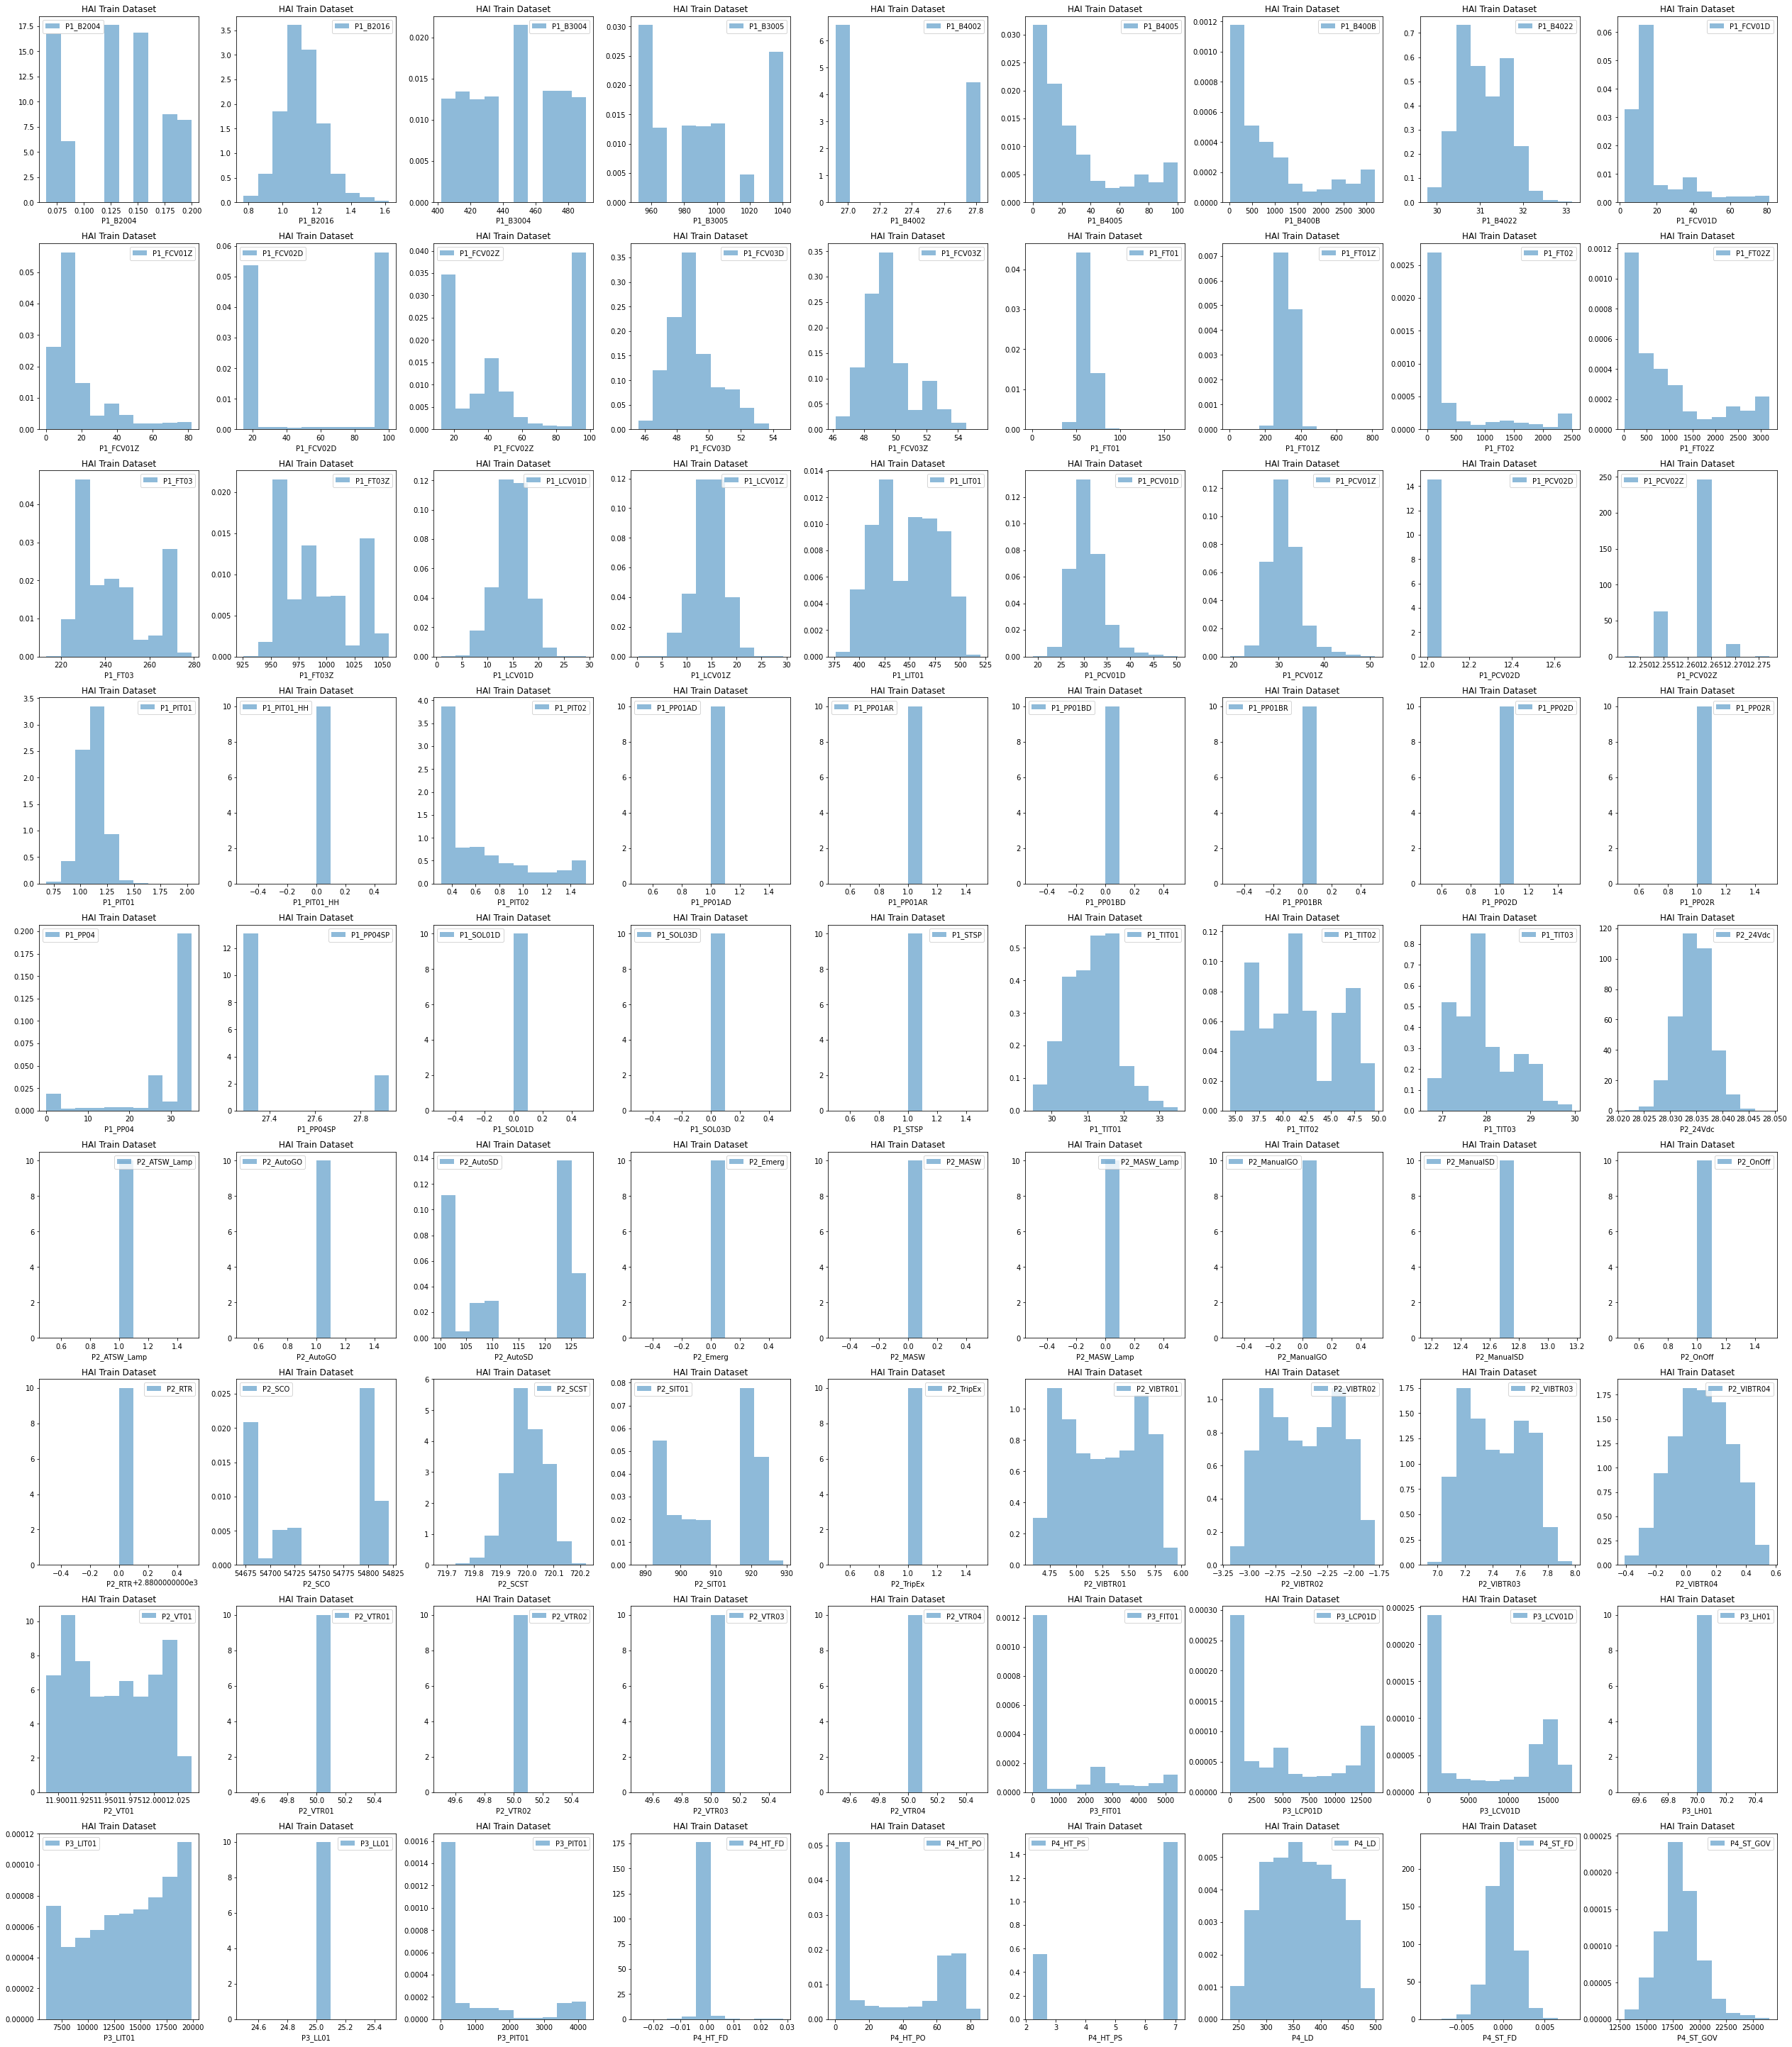

--------------------------------------------------------------------------- 
 IndexError Traceback (most recent call last)
 <command-2907355549378479> in <module> 
 2 features = list ( train_raw . columns . values ) 
 3 target = 'Attack' 
 ----> 4 dataset_summary ( train_raw_no_time , features , target , "train" ) 
 5 
 6 # count, mean, std, min, 25%, 50%, 75%, max 

 <command-2907355549378458> in dataset_summary (df, features, target, df_type) 
 16 if df_type == "train" : 
 17 for i , name in enumerate ( all_vars ) : 
 ---> 18 axs [ i ] . hist ( df [ name ] , alpha = 0.5 , density = True , label = name ) 
 19 axs [ i ] . set_xlabel ( name ) 
 20 axs [ i ] . set_title ( 'HAI Train Dataset' ) 

 IndexError : index 81 is out of bounds for axis 0 with size 81

In [0]:
train_raw_no_time = train_df_raw.drop(['timestamp'], axis =1).copy()
features = list(train_raw.columns.values)
target = 'Attack'
dataset_summary(train_raw_no_time, features, target, "train")

# count, mean, std, min, 25%, 50%, 75%, max

P1_B2004 P1_B2016 P1_B3004 P1_B3005 P1_B4002 P1_B4005 P1_B400B P1_B4022 P1_FCV01D P1_FCV01Z P1_FCV02D P1_FCV02Z P1_FCV03D P1_FCV03Z P1_FT01 P1_FT01Z P1_FT02 P1_FT02Z P1_FT03 P1_FT03Z P1_LCV01D P1_LCV01Z P1_LIT01 P1_PCV01D P1_PCV01Z P1_PCV02D P1_PCV02Z P1_PIT01 P1_PIT01_HH P1_PIT02 P1_PP01AD P1_PP01AR P1_PP01BD P1_PP01BR P1_PP02D P1_PP02R P1_PP04 P1_PP04SP P1_SOL01D P1_SOL03D P1_STSP P1_TIT01 P1_TIT02 P1_TIT03 P2_24Vdc P2_ATSW_Lamp P2_AutoGO P2_AutoSD P2_Emerg P2_MASW P2_MASW_Lamp P2_ManualGO P2_ManualSD P2_OnOff P2_RTR P2_SCO P2_SCST P2_SIT01 P2_TripEx P2_VIBTR01 P2_VIBTR02 P2_VIBTR03 P2_VIBTR04 P2_VT01 P2_VTR01 P2_VTR02 P2_VTR03 P2_VTR04 P3_FIT01 P3_LCP01D P3_LCV01D P3_LH01 P3_LIT01 P3_LL01 P3_PIT01 P4_HT_FD P4_HT_PO P4_HT_PS P4_LD P4_ST_FD P4_ST_GOV P4_ST_LD P4_ST_PO P4_ST_PS P4_ST_PT01 P4_ST_TT01 Attack 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 86400.0 0.1267813355595833 1.1148783346064814 449.182239556117 1004.4884641429628 27.754849555562963 21.455218706134257 684.2342972121528 31.54851779039352 16.171110291319444 15.921492494907406 62.185901524537044 53.84042227233797 49.40108099699074 49.9546578892361 63.554135648958336 330.7670292971065 244.4950306193287 684.2666456087962 249.5227628508102 1004.4912464424767 15.232709471180556 15.07124077511574 449.90493005300925 30.357984739004632 30.848991297106473 12.001176364930556 11.935542401967592 1.114719238425926 0.0 0.5721718575231483 1.0 1.0 0.0 0.0 1.0 1.0 30.26630022604167 27.79620552 0.0 0.0 1.0 31.577997648379636 42.72525996539351 28.135595587500003 28.034307578009265 0.9188773148148148 0.9188773148148148 116.31296652627316 0.0 0.08112268518518519 0.08112268518518519 0.08112268518518519 12.743439570592129 1.0 2880.0 54721.15542824074 719.9960670815972 904.987337962963 1.0 5.092231543981482 -2.459466662037037 7.184605325231481 0.17047383333333332 11.948349152893519 50.0 50.0 50.0 50.0 1116.742673611111 4873.662592592593 7048.826296296296 70.0 13515.36855324074 25.0 787.2582986111111 1.1872546296296298E-4 32.67355743229167 0.716041982 365.849156715162 -2.7098611111111107E-5 18186.160972222224 333.0438692743055 333.31510262800924 20.989593509999995 9975.377488425926 27226.147638888888 0.9795138888888889 0.04376930508883382 0.11208207280905767 30.97266999954798 27.23435078227537 0.02979847117722374 21.073703101866332 667.0942712466791 0.3399967804855059 10.031640240294303 10.159001887790705 40.772148640125664 28.03264136764282 1.427325460902682 1.5140082759702138 8.793604086361192 43.610062969993116 493.33220886219846 667.1978083164512 13.872905867558908 27.58101724844867 2.85762626380983 2.8596862281705753 31.970357185144607 3.3109409042541262 3.3611672180280143 0.0572026867517235 0.2240928796232529 0.10927432086600021 0.0 0.2803459826107888 0.0 0.0 0.0 0.0 0.0 0.0 8.108487518719581 0.0 0.0 0.0 0.0 0.5336158882978931 3.2402148348332633 0.6125734158726764 0.0033994924037674483 0.2730250133152174 0.2730250133152174 7.60802942999722 0.0 0.2730250133152174 0.2730250133152174 0.2730250133152174 0.10890694759186544 0.0 0.0 135.63765486819364 0.0696943795187877 25.766570554632818 0.0 0.3837526229034144 0.3484381851310685 0.27628479237301745 0.19563939071473177 0.0445938488169702 0.0 0.0 0.0 0.0 1695.1679011198223 5104.584512387677 6815.743654090211 0.0 4019.8680651955415 0.0 1324.7333685476513 0.002022964623627249 31.344725601215686 0.0 59.0997039

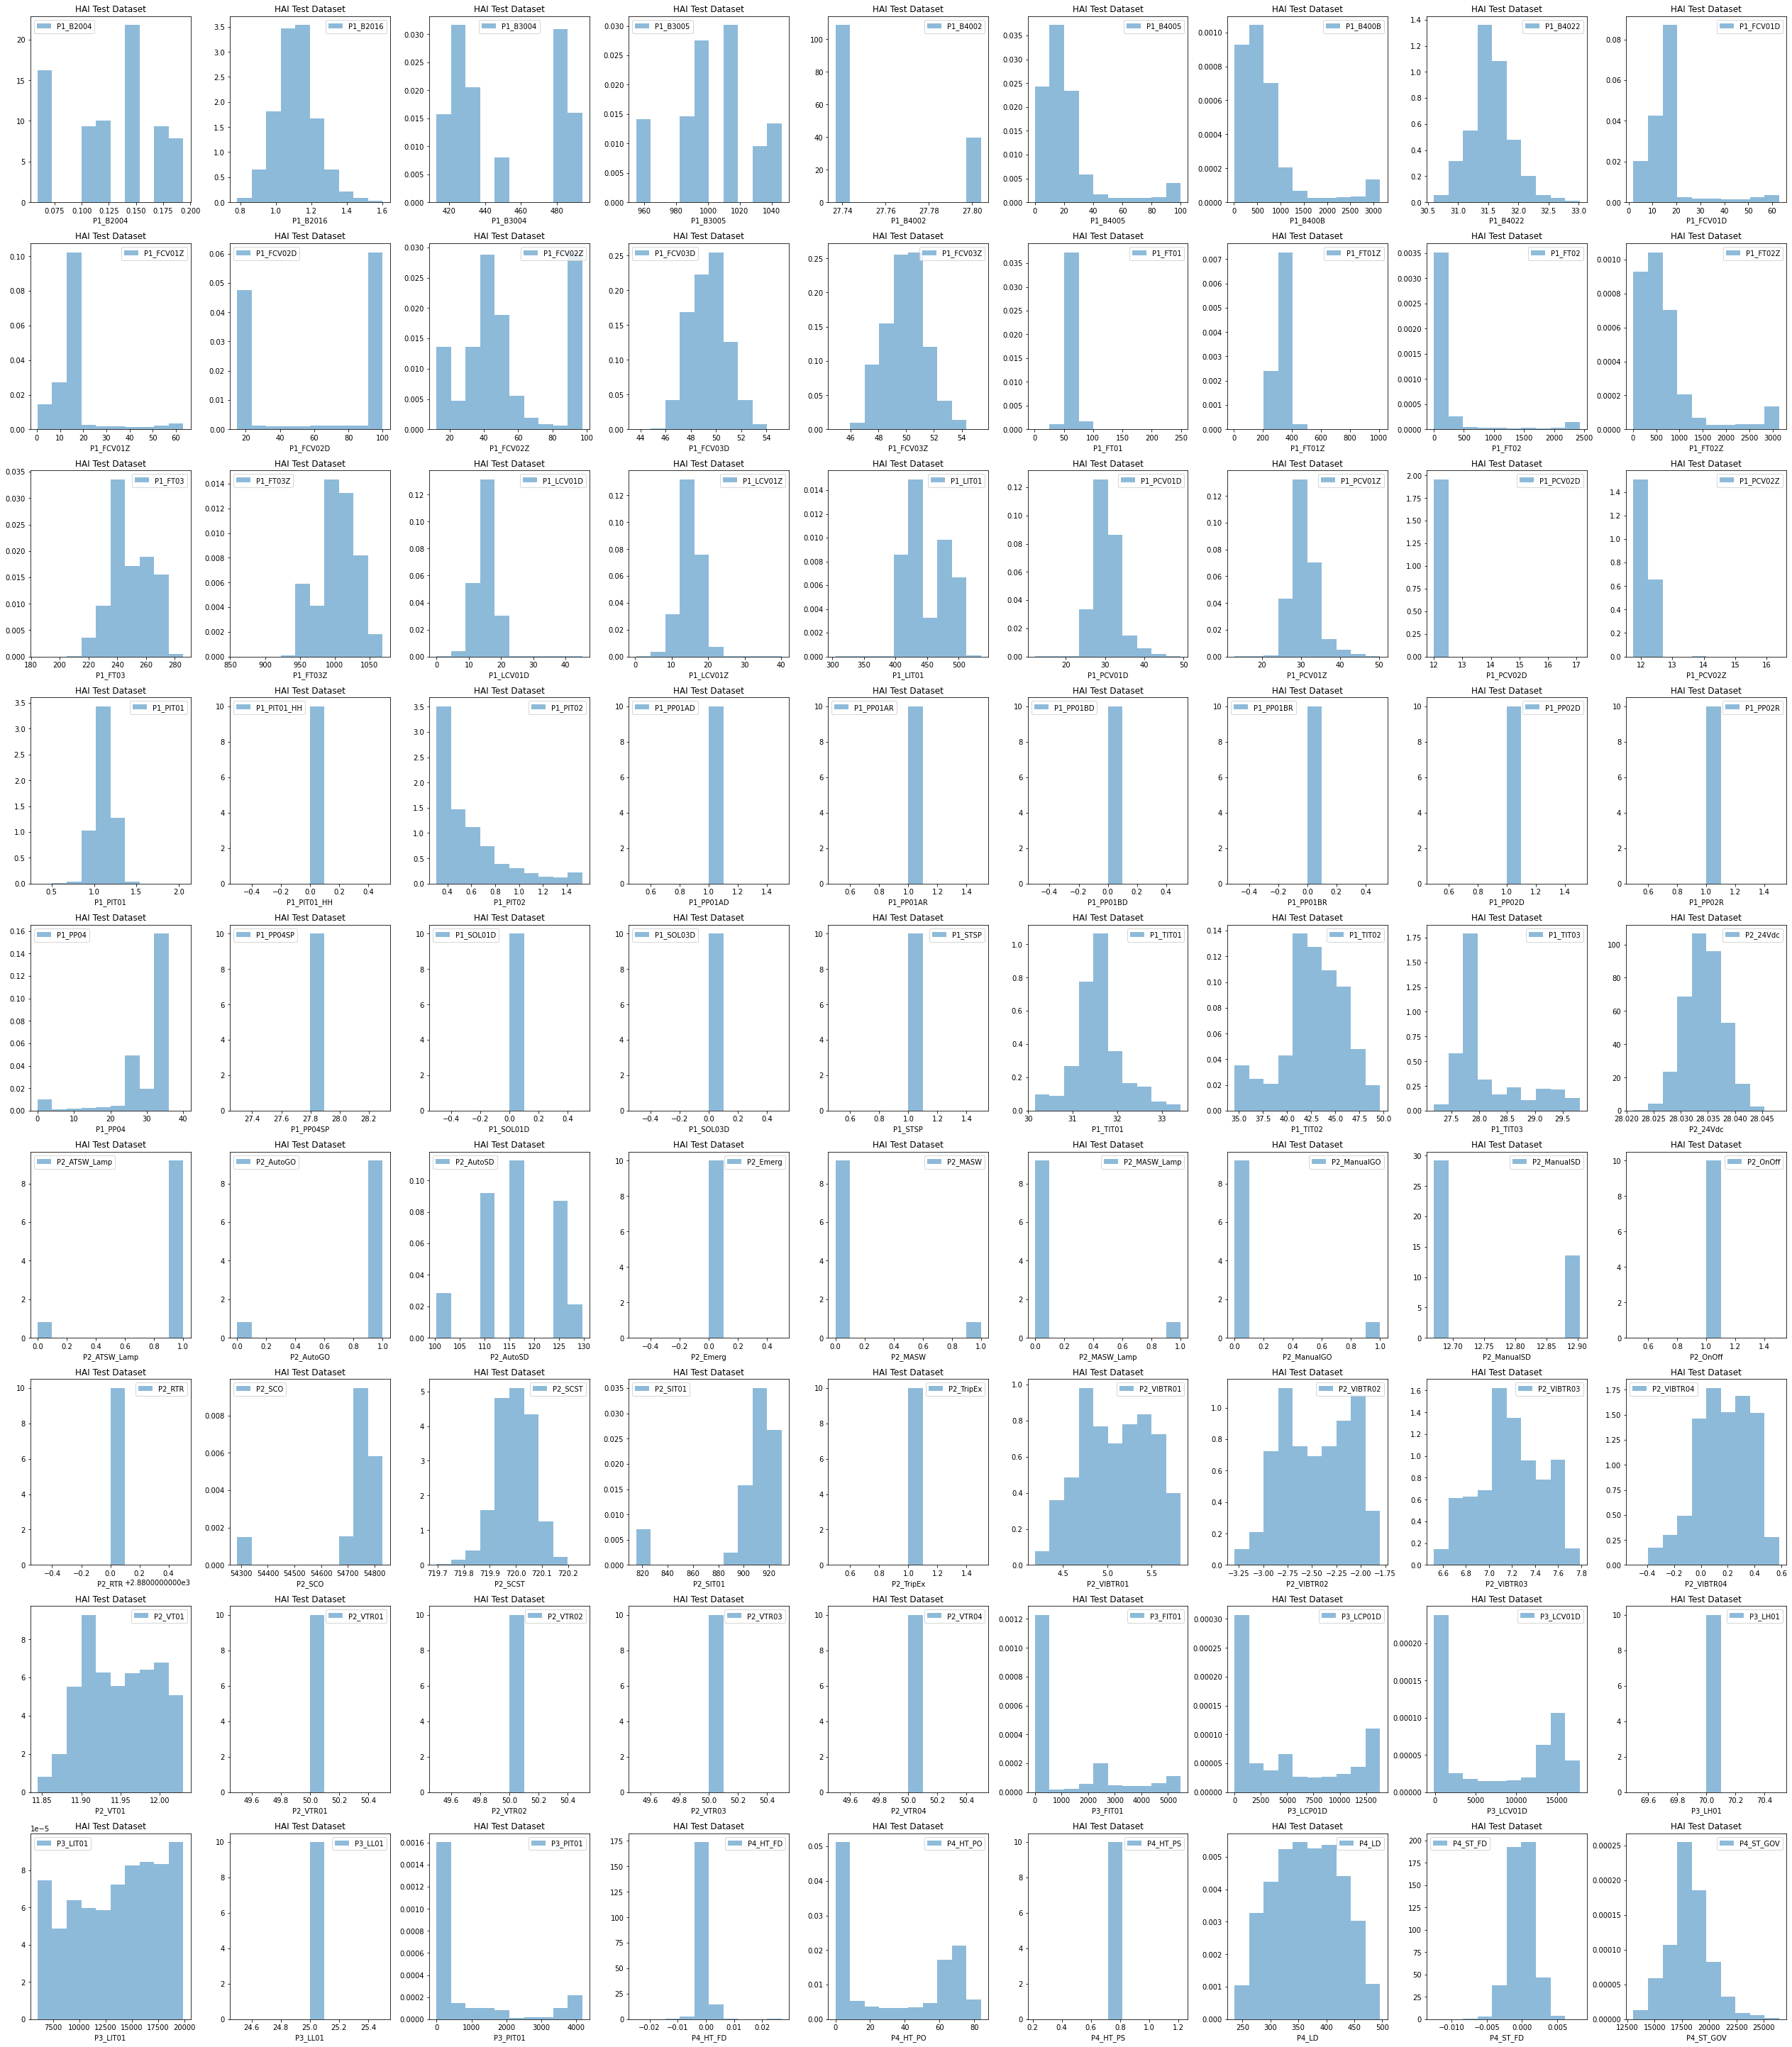

--------------------------------------------------------------------------- 
 IndexError Traceback (most recent call last)
 <command-2907355549378480> in <module> 
 2 features = list ( test_raw . columns . values ) 
 3 target = 'Attack' 
 ----> 4 dataset_summary ( test_raw_no_time , features , target , "test" ) 
 5 # count, mean, std, min, 25%, 50%, 75%, max 

 <command-2907355549378458> in dataset_summary (df, features, target, df_type) 
 23 else : 
 24 for i , name in enumerate ( all_vars ) : 
 ---> 25 axs [ i ] . hist ( df [ name ] , alpha = 0.5 , density = True , label = name ) 
 26 axs [ i ] . set_xlabel ( name ) 
 27 axs [ i ] . set_title ( 'HAI Test Dataset' ) 

 IndexError : index 81 is out of bounds for axis 0 with size 81

In [0]:
test_raw_no_time = test_df_raw.drop(['timestamp'], axis =1).copy()
features = list(test_raw.columns.values)
target = 'Attack'
dataset_summary(test_raw_no_time, features, target, "test")
# count, mean, std, min, 25%, 50%, 75%, max


## Assess multicollinearity

In [0]:
# assess multicollinearity
co_lin_df = train_raw.copy()
co_lin_df['constant'] = 1
print('Variance Inflation Factors')
print(calc_vif(co_lin_df))

print('')
print('Corelation Matrix')
rs = np.random.RandomState(0)
corr = train_raw.corr().abs().copy() # added abs, might not work
corr.style.background_gradient(cmap='coolwarm')

Variance Inflation Factors
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
 variables VIF
0 P1_B2004 505.077643
1 P1_B2016 3460.857107
2 P1_B3004 75.291377
3 P1_B3005 120.385574
4 P1_B4002 4467.739587
.. ... ...
82 P4_ST_PO 9632.576845
83 P4_ST_PS 2.708747
84 P4_ST_PT01 25.411052
85 P4_ST_TT01 397.714824
86 constant 0.000000

[87 rows x 2 columns]

Corelation Matrix
Out[130]: All-NaN slice encountered
All-NaN slice encountered

P1_B2004 P1_B2016 P1_B3004 P1_B3005 P1_B4002 P1_B4005 P1_B400B P1_B4022 P1_FCV01D P1_FCV01Z P1_FCV02D P1_FCV02Z P1_FCV03D P1_FCV03Z P1_FT01 P1_FT01Z P1_FT02 P1_FT02Z P1_FT03 P1_FT03Z P1_LCV01D P1_LCV01Z P1_LIT01 P1_PCV01D P1_PCV01Z P1_PCV02D P1_PCV02Z P1_PIT01 P1_PIT01_HH P1_PIT02 P1_PP01AD P1_PP01AR P1_PP01BD P1_PP01BR P1_PP02D P1_PP02R P1_PP04 P1_PP04SP P1_SOL01D P1_SOL03D P1_STSP P1_TIT01 P1_TIT02 P1_TIT03 P2_24Vdc P2_ATSW_Lamp P2_AutoGO P2_AutoSD P2_Emerg P2_MASW P2_MASW_Lamp P2_ManualGO P2_ManualSD P2_OnOff P2_RTR P2_SCO P2_SCST P2_SIT01 P2_TripEx P2_VIBTR01 P2_VIBTR02 P2_VIBTR03 P2_VIBTR04 P2_VT01 P2_VTR01 P2_VTR02 P2_VTR03 P2_VTR04 P3_FIT01 P3_LCP01D P3_LCV01D P3_LH01 P3_LIT01 P3_LL01 P3_PIT01 P4_HT_FD P4_HT_PO P4_HT_PS P4_LD P4_ST_FD P4_ST_GOV P4_ST_LD P4_ST_PO P4_ST_PS P4_ST_PT01 P4_ST_TT01 
 
 P1_B2004 
 1.000000 
 0.473406 
 0.254434 
 0.051893 
 0.385150 
 0.126154 
 0.128439 
 0.246884 
 0.214961 
 0.214213 
 0.019044 
 0.001974 
 0.169459 
 0.186382 
 0.042732 
 0.042851 
 0.191857 
 0.128388 
 0.051216 
 0.052283 
 0.333841 
 0.339113 
 0.248727 
 0.410660 
 0.409900 
 0.007845 
 0.081002 
 0.515419 
 nan 
 0.220475 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.028030 
 0.624454 
 nan 
 nan 
 nan 
 0.161490 
 0.039867 
 0.188323 
 0.013033 
 nan 
 nan 
 0.488772 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.488879 
 0.002253 
 0.494636 
 nan 
 0.010769 
 0.014623 
 0.009002 
 0.035357 
 0.006902 
 nan 
 nan 
 nan 
 nan 
 0.012946 
 0.041757 
 0.043195 
 nan 
 0.204332 
 nan 
 0.000638 
 0.003883 
 0.043241 
 0.600405 
 0.090863 
 0.000068 
 0.105173 
 0.106976 
 0.116895 
 0.063132 
 0.493654 
 0.161095 
 
 
 P1_B2016 
 0.473406 
 1.000000 
 0.074712 
 0.054269 
 0.205786 
 0.006505 
 0.014467 
 0.421959 
 0.061138 
 0.063166 
 0.043419 
 0.040807 
 0.092454 
 0.102596 
 0.113403 
 0.111463 
 0.050409 
 0.013351 
 0.043936 
 0.049498 
 0.314809 
 0.299241 
 0.100333 
 0.717289 
 0.659977 
 0.002805 
 0.032169 
 0.592740 
 nan 
 0.124954 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.012887 
 0.293018 
 nan 
 nan 
 nan 
 0.081608 
 0.003724 
 0.067696 
 0.007949 
 nan 
 nan 
 0.238189 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.238353 
 0.011628 
 0.243562 
 nan 
 0.014862 
 0.014376 
 0.017087 
 0.028047 
 0.001251 
 nan 
 nan 
 nan 
 nan 
 0.421944 
 0.550012 
 0.429660 
 nan 
 0.355642 
 nan 
 0.398663 
 0.001716 
 0.426991 
 0.263391 
 0.806204 
 0.102539 
 0.924669 
 0.886888 
 0.929153 
 0.013082 
 0.567807 
 0.080697 
 
 
 P1_B3004 
 0.254434 
 0.074712 
 1.000000 
 0.131735 
 0.103299 
 0.002750 
 0.001680 
 0.100037 
 0.072683 
 0.073127 
 0.022606 
 0.037345 
 0.420466 
 0.438197 
 0.078184 
 0.078337 
 0.032552 
 0.001576 
 0.111071 
 0.131263 
 0.026031 
 0.026160 
 0.975131 
 0.092146 
 0.094558 
 0.003686 
 0.229706 
 0.079843 
 nan 
 0.131808 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.027800 
 0.349394 
 nan 
 nan 
 nan 
 0.113264 
 0.000322 
 0.133418 
 0.015193 
 nan 
 nan 
 0.249036 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.249322 
 0.001485 
 0.242677 
 nan 
 0.059802 
 0.109805 
 0.049008 
 0.230065 
 0.056556 
 nan 
 nan 
 nan 
 nan 
 0.002062 
 0.000779 
 0.037697 
 nan 
 0.008581 
 nan 
 0.004516 
 0.000521 
 0.037485 
 0.312588 
 0.005580 
 0.003003 
 0.025040 
 0.021366 
 0.023330 
 0.390147 
 0.075288 
 0.112622 
 
 
 P1_B3005 
 0.051893 
 0.054269 
 0.131735 
 1.000000 
 0.264378 
 0.369650 
 0.376575 
 0.190569 
 0.368056 
 0.368155 
 0.237944 
 0.279354 
 0.795061 
 0.780378 
 0.532007 
 0.532604 
 0.368918 
 <td id="T_a9479_row3_col17

## choose the features with low collinearity (close to zero)
https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python

In [0]:
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
# print(upper_tri)
upper_tri.style.background_gradient(cmap='coolwarm')

Out[131]:

P1_B2004 P1_B2016 P1_B3004 P1_B3005 P1_B4002 P1_B4005 P1_B400B P1_B4022 P1_FCV01D P1_FCV01Z P1_FCV02D P1_FCV02Z P1_FCV03D P1_FCV03Z P1_FT01 P1_FT01Z P1_FT02 P1_FT02Z P1_FT03 P1_FT03Z P1_LCV01D P1_LCV01Z P1_LIT01 P1_PCV01D P1_PCV01Z P1_PCV02D P1_PCV02Z P1_PIT01 P1_PIT01_HH P1_PIT02 P1_PP01AD P1_PP01AR P1_PP01BD P1_PP01BR P1_PP02D P1_PP02R P1_PP04 P1_PP04SP P1_SOL01D P1_SOL03D P1_STSP P1_TIT01 P1_TIT02 P1_TIT03 P2_24Vdc P2_ATSW_Lamp P2_AutoGO P2_AutoSD P2_Emerg P2_MASW P2_MASW_Lamp P2_ManualGO P2_ManualSD P2_OnOff P2_RTR P2_SCO P2_SCST P2_SIT01 P2_TripEx P2_VIBTR01 P2_VIBTR02 P2_VIBTR03 P2_VIBTR04 P2_VT01 P2_VTR01 P2_VTR02 P2_VTR03 P2_VTR04 P3_FIT01 P3_LCP01D P3_LCV01D P3_LH01 P3_LIT01 P3_LL01 P3_PIT01 P4_HT_FD P4_HT_PO P4_HT_PS P4_LD P4_ST_FD P4_ST_GOV P4_ST_LD P4_ST_PO P4_ST_PS P4_ST_PT01 P4_ST_TT01 
 
 P1_B2004 
 nan 
 0.473406 
 0.254434 
 0.051893 
 0.385150 
 0.126154 
 0.128439 
 0.246884 
 0.214961 
 0.214213 
 0.019044 
 0.001974 
 0.169459 
 0.186382 
 0.042732 
 0.042851 
 0.191857 
 0.128388 
 0.051216 
 0.052283 
 0.333841 
 0.339113 
 0.248727 
 0.410660 
 0.409900 
 0.007845 
 0.081002 
 0.515419 
 nan 
 0.220475 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.028030 
 0.624454 
 nan 
 nan 
 nan 
 0.161490 
 0.039867 
 0.188323 
 0.013033 
 nan 
 nan 
 0.488772 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.488879 
 0.002253 
 0.494636 
 nan 
 0.010769 
 0.014623 
 0.009002 
 0.035357 
 0.006902 
 nan 
 nan 
 nan 
 nan 
 0.012946 
 0.041757 
 0.043195 
 nan 
 0.204332 
 nan 
 0.000638 
 0.003883 
 0.043241 
 0.600405 
 0.090863 
 0.000068 
 0.105173 
 0.106976 
 0.116895 
 0.063132 
 0.493654 
 0.161095 
 
 
 P1_B2016 
 nan 
 nan 
 0.074712 
 0.054269 
 0.205786 
 0.006505 
 0.014467 
 0.421959 
 0.061138 
 0.063166 
 0.043419 
 0.040807 
 0.092454 
 0.102596 
 0.113403 
 0.111463 
 0.050409 
 0.013351 
 0.043936 
 0.049498 
 0.314809 
 0.299241 
 0.100333 
 0.717289 
 0.659977 
 0.002805 
 0.032169 
 0.592740 
 nan 
 0.124954 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.012887 
 0.293018 
 nan 
 nan 
 nan 
 0.081608 
 0.003724 
 0.067696 
 0.007949 
 nan 
 nan 
 0.238189 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.238353 
 0.011628 
 0.243562 
 nan 
 0.014862 
 0.014376 
 0.017087 
 0.028047 
 0.001251 
 nan 
 nan 
 nan 
 nan 
 0.421944 
 0.550012 
 0.429660 
 nan 
 0.355642 
 nan 
 0.398663 
 0.001716 
 0.426991 
 0.263391 
 0.806204 
 0.102539 
 0.924669 
 0.886888 
 0.929153 
 0.013082 
 0.567807 
 0.080697 
 
 
 P1_B3004 
 nan 
 nan 
 nan 
 0.131735 
 0.103299 
 0.002750 
 0.001680 
 0.100037 
 0.072683 
 0.073127 
 0.022606 
 0.037345 
 0.420466 
 0.438197 
 0.078184 
 0.078337 
 0.032552 
 0.001576 
 0.111071 
 0.131263 
 0.026031 
 0.026160 
 0.975131 
 0.092146 
 0.094558 
 0.003686 
 0.229706 
 0.079843 
 nan 
 0.131808 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.027800 
 0.349394 
 nan 
 nan 
 nan 
 0.113264 
 0.000322 
 0.133418 
 0.015193 
 nan 
 nan 
 0.249036 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.249322 
 0.001485 
 0.242677 
 nan 
 0.059802 
 0.109805 
 0.049008 
 0.230065 
 0.056556 
 nan 
 nan 
 nan 
 nan 
 0.002062 
 0.000779 
 0.037697 
 nan 
 0.008581 
 nan 
 0.004516 
 0.000521 
 0.037485 
 0.312588 
 0.005580 
 0.003003 
 0.025040 
 0.021366 
 0.023330 
 0.390147 
 0.075288 
 0.112622 
 
 
 <th id="T_e0230_level0_r

In [0]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.3)] # change this threshold to see how affects model, example had > 0.95
print(to_drop)


['P1_B2016', 'P1_B4002', 'P1_B4005', 'P1_B400B', 'P1_B4022', 'P1_FCV01D', 'P1_FCV01Z', 'P1_FCV02D', 'P1_FCV02Z', 'P1_FCV03D', 'P1_FCV03Z', 'P1_FT01', 'P1_FT01Z', 'P1_FT02', 'P1_FT02Z', 'P1_FT03', 'P1_FT03Z', 'P1_LCV01D', 'P1_LCV01Z', 'P1_LIT01', 'P1_PCV01D', 'P1_PCV01Z', 'P1_PIT01', 'P1_PIT02', 'P1_PP04SP', 'P1_TIT01', 'P1_TIT02', 'P1_TIT03', 'P2_AutoSD', 'P2_SCO', 'P2_SIT01', 'P2_VIBTR03', 'P2_VIBTR04', 'P2_VT01', 'P3_FIT01', 'P3_LCP01D', 'P3_LCV01D', 'P3_LIT01', 'P3_PIT01', 'P4_HT_PO', 'P4_HT_PS', 'P4_LD', 'P4_ST_GOV', 'P4_ST_LD', 'P4_ST_PO', 'P4_ST_PS', 'P4_ST_PT01', 'P4_ST_TT01']

## can do feature selection once fitted on linear svm - do after
https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

## EDA to find hyper-parameters

# Normalize data
- use min max values so they fall within 0-1
- using the exponential weighted function after normalization to smooth noise generated by sensors

In [0]:
train_df = normalize(train_raw).ewm(alpha=0.9).mean() # normalize and smooth noise
test_df = normalize(test_raw).ewm(alpha=0.9).mean() # normalize and smooth noise
test_df

Out[133]:

P1_B2004 
 P1_B2016 
 P1_B3004 
 P1_B3005 
 P1_B4002 
 P1_B4005 
 P1_B400B 
 P1_B4022 
 P1_FCV01D 
 P1_FCV01Z 
 P1_FCV02D 
 P1_FCV02Z 
 P1_FCV03D 
 P1_FCV03Z 
 P1_FT01 
 P1_FT01Z 
 P1_FT02 
 P1_FT02Z 
 P1_FT03 
 P1_FT03Z 
 P1_LCV01D 
 P1_LCV01Z 
 P1_LIT01 
 P1_PCV01D 
 P1_PCV01Z 
 P1_PCV02D 
 P1_PCV02Z 
 P1_PIT01 
 P1_PIT01_HH 
 P1_PIT02 
 P1_PP01AD 
 P1_PP01AR 
 P1_PP01BD 
 P1_PP01BR 
 P1_PP02D 
 P1_PP02R 
 P1_PP04 
 P1_PP04SP 
 P1_SOL01D 
 P1_SOL03D 
 ... 
 P2_AutoGO 
 P2_AutoSD 
 P2_Emerg 
 P2_MASW 
 P2_MASW_Lamp 
 P2_ManualGO 
 P2_ManualSD 
 P2_OnOff 
 P2_RTR 
 P2_SCO 
 P2_SCST 
 P2_SIT01 
 P2_TripEx 
 P2_VIBTR01 
 P2_VIBTR02 
 P2_VIBTR03 
 P2_VIBTR04 
 P2_VT01 
 P2_VTR01 
 P2_VTR02 
 P2_VTR03 
 P2_VTR04 
 P3_FIT01 
 P3_LCP01D 
 P3_LCV01D 
 P3_LH01 
 P3_LIT01 
 P3_LL01 
 P3_PIT01 
 P4_HT_FD 
 P4_HT_PO 
 P4_HT_PS 
 P4_LD 
 P4_ST_FD 
 P4_ST_GOV 
 P4_ST_LD 
 P4_ST_PO 
 P4_ST_PS 
 P4_ST_PT01 
 P4_ST_TT01 
 
 
 
 
 0 
 0.0 
 0.319253 
 0.226384 
 0.874345 
 0.0 
 0.149131 
 0.119954 
 0.380713 
 0.214280 
 0.254609 
 0.804901 
 0.416794 
 0.604505 
 0.605951 
 0.226994 
 0.294841 
 0.033856 
 0.136455 
 0.784350 
 0.825366 
 0.261376 
 0.285824 
 0.577290 
 0.467547 
 0.480318 
 0.0 
 0.004951 
 0.519110 
 0.0 
 0.114728 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.875000 
 0.0 
 0.0 
 0.0 
 ... 
 1.0 
 1.000000 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.998168 
 0.594801 
 0.973913 
 0.0 
 0.488889 
 0.841266 
 0.258656 
 0.833195 
 0.843806 
 0.0 
 0.0 
 0.0 
 0.0 
 0.028509 
 0.000000 
 0.854334 
 0.0 
 0.307153 
 0.0 
 0.000480 
 0.492266 
 0.854311 
 0.0 
 0.464068 
 0.632979 
 0.380245 
 0.220832 
 0.388082 
 0.0 
 0.514523 
 0.306061 
 
 
 1 
 0.0 
 0.317602 
 0.226384 
 0.874345 
 0.0 
 0.149516 
 0.127166 
 0.379417 
 0.208559 
 0.249316 
 0.982264 
 0.414102 
 0.605222 
 0.605951 
 0.226297 
 0.293042 
 0.035860 
 0.144533 
 0.784350 
 0.825366 
 0.261080 
 0.285824 
 0.575879 
 0.465380 
 0.479947 
 0.0 
 0.004951 
 0.519110 
 0.0 
 0.113017 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.875000 
 0.0 
 0.0 
 0.0 
 ... 
 1.0 
 1.000000 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.996503 
 0.310879 
 0.966008 
 0.0 
 0.662571 
 0.758693 
 0.403105 
 0.848048 
 0.681953 
 0.0 
 0.0 
 0.0 
 0.0 
 0.027512 
 0.000000 
 0.805589 
 0.0 
 0.305642 
 0.0 
 0.000262 
 0.953842 
 0.881545 
 0.0 
 0.448176 
 0.483515 
 0.378880 
 0.231198 
 0.382153 
 0.0 
 0.512637 
 0.286777 
 
 
 2 
 0.0 
 0.314193 
 0.226384 
 0.874345 
 0.0 
 0.149880 
 0.135535 
 0.373748 
 0.202008 
 0.232229 
 0.998242 
 0.427276 
 0.605998 
 0.605951 
 0.224852 
 0.291989 
 0.035047 
 0.141258 
 0.780955 
 0.822617 
 0.261771 
 0.285824 
 0.573753 
 0.462790 
 0.472564 
 0.0 
 0.003464 
 0.513505 
 0.0 
 0.106651 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.875000 
 0.0 
 0.0 
 0.0 
 ... 
 1.0 
 1.000000 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.994703 
 0.398610 
 0.973130 
 0.0 
 0.248583 
 0.503413 
 0.267273 
 0.558650 
 0.435162 
 0.0 
 0.0 
 0.0 
 0.0 
 0.026434 
 0.000000 
 0.707807 
 0.0 
 0.303684 
 0.0 
 0.000242 
 0.403186 
 0.843807 
 0.0 
 0.431371 
 0.419516 
 0.378013 
 0.246665 
 0.378647 
 0.0 
 0.512467 
 0.279580 
 
 
 3 
 0.0 
 0.306199 
 0.226384 
 0.874345 
 0.0 
 0.150110 
 0.144361 
 0.364506 
 0.204942 
 0.229555 
 0.999824 
 0.448444 
 0.608873 
 0.605951 
 0.224709 
 0.290103 
 0.033691 
 0.135792 
 0.787402 
 0.827838 
 0.263613 
 0.285824 
 0.573743 
 0.461293 
 0.459533 
 0.0 
 0.004802 
 0.506553 
 0.0 
 0.095303 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.875000 
 0.0 
 0.0 
 0.0 
 ... 
 1.0 
 1.000000 
 0.0 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.996174 
 0.577262 
 0.950354 
 0.0 
 0.726276 
 0.546438 
 0.548329 
 0.747271 
 0.481361 
 0.0 
 0.0 
 0.0 
 0.0 
 0.026163 
 0.000521 
 0.673994 
 0.0 
 0.301994 
 0.0 
 0.000240 
 0.604318 
 0.720963 
 0.0 
 0.404483 
 0.520250 
 0.371172 
 0.255393 
 0.373946 
 0.0 
 0.512450 
 0.267957 
 
 
 4 
 0.0 
 0.302384 
 0.226384 
 0.874345 
 0.0 
 0.150440 
 0.141244 
 0.363582 
 0.215522 
 0.2

In [0]:
boundary_check(train_df) # making sure normalization within boundaries
boundary_check(test_df)

Out[134]: (False, False, False)

## Removing Features

In [0]:
# creating dictionary of all columns
col_names = list(train_df_raw.columns.values)
keys = list(range(88))
col_dict = {keys[i]: col_names[i] for i in range(len(keys))}


In [0]:
# grabbing column names for these columns discussed 

# All columns 28,30,31,32,33,34,35,38,39,40,48,53,54,58,64,65,66,67 have a value of 0 when normalized 

# list of columns with no change:
# 28,30,31,32,33,34,35,38,39,40, 48,53,54,58,64,65,66,67

# list of columns in the form of categorical data:
# 45, 46, 49,50,51,71,73

norm_0 =[28,30,31,32,33,34,35,38,39,40,48,53,54,58,64,65,66,67]
no_change = [28,30,31,32,33,34,35,38,39,40, 48,53,54,58,64,65,66,67]
cat = [45, 46, 49,50,51,71,73]

def getname(nums):
    lst=[]
    for i in nums:
        for key, value in col_dict.items():
            if key==i:
                lst.append(value)
    return lst

norm_0_names = getname(norm_0)
no_change_names = getname(no_change)
cat_names = getname(cat)


In [0]:
cols_no_var = [ 'P1_PIT01_HH','P1_PP02R','P1_STSP','P2_AutoGO','P2_ManualGO','P2_TripEx', 'P2_RTR','P2_VTR04','P3_LH01','P3_LL01']

In [0]:
# collinearity, 0 value when normalized, no change in values, categorical
# with a threshold of collinearity < 0.3: 72 columns to drop here, not including time and attack
all_cols_to_drop_dup = to_drop + norm_0_names + no_change_names + cat_names + cols_no_var
all_cols_to_drop = [*set(all_cols_to_drop_dup)] # dropd duplicates
len(all_cols_to_drop)

Out[138]: 75

In [0]:
all_cols_to_drop

Out[139]: ['P3_PIT01',
 'P4_ST_LD',
 'P1_PP01BR',
 'P1_B4002',
 'P1_FT02Z',
 'P1_PIT02',
 'P3_LIT01',
 'P3_FIT01',
 'P4_ST_TT01',
 'P2_VTR03',
 'P2_24Vdc',
 'P1_LCV01D',
 'P1_PIT01_HH',
 'P1_PP01AR',
 'P2_VT01',
 'P1_STSP',
 'P2_AutoGO',
 'P1_FCV03D',
 'P1_SOL01D',
 'P2_VIBTR04',
 'P2_TripEx',
 'P1_PP01BD',
 'P1_FCV03Z',
 'P1_LCV01Z',
 'P3_LL01',
 'P1_PCV01D',
 'P1_FCV01D',
 'P1_PP02D',
 'P1_SOL03D',
 'P2_VTR01',
 'P1_PIT01',
 'P2_ManualSD',
 'P1_FCV02Z',
 'P1_FCV01Z',
 'P2_OnOff',
 'P1_FT01Z',
 'P1_FT02',
 'P4_HT_PO',
 'P1_B4005',
 'P2_MASW',
 'P1_LIT01',
 'P1_PP02R',
 'P4_HT_PS',
 'P1_PP01AD',
 'P1_TIT03',
 'P2_VTR02',
 'P2_MASW_Lamp',
 'P2_SCO',
 'P1_FT01',
 'P2_RTR',
 'P2_ATSW_Lamp',
 'P2_VTR04',
 'P4_ST_PS',
 'P4_ST_GOV',
 'P3_LCP01D',
 'P2_ManualGO',
 'P4_ST_PT01',
 'P2_AutoSD',
 'P1_PCV01Z',
 'P1_TIT01',
 'P1_B4022',
 'P2_VIBTR03',
 'P1_B2016',
 'P1_B400B',
 'P1_FCV02D',
 'P4_LD',
 'P1_FT03',
 'P1_TIT02',
 'P2_SIT01',
 'P3_LCV01D',
 'P3_LH01',
 'P4_ST_PO',
 'P2_Emerg',
 'P1_FT03Z',
 'P1_PP04SP']

In [0]:
train = train_df.drop(all_cols_to_drop, axis=1).copy()
test = test_df.drop(all_cols_to_drop, axis=1).copy()
train.shape # 11 features instead of 86y

Out[140]: (93601, 11)

## A look at Attack data vs Normal data to identify key features

In [0]:
# test data with attack column

attack_normal = test_raw_no_time.drop(all_cols_to_drop, axis=1).copy()
attack = attack_normal.loc[attack_normal['Attack'] == -1]
normal = attack_normal.loc[attack_normal['Attack'] == 1]
attack.shape

Out[141]: (885, 12)

In [0]:
attack.head(10)

Out[142]:

P1_B2004 
 P1_B3004 
 P1_B3005 
 P1_PCV02D 
 P1_PCV02Z 
 P1_PP04 
 P2_SCST 
 P2_VIBTR01 
 P2_VIBTR02 
 P4_HT_FD 
 P4_ST_FD 
 Attack 
 
 
 
 
 20481 
 0.15256 
 433.32816 
 954.83789 
 12.0 
 11.78894 
 35.0 
 720.02490 
 5.2125 
 -2.9036 
 0.00065 
 0.00152 
 -1 
 
 
 20482 
 0.15256 
 433.32816 
 954.83789 
 12.0 
 11.78894 
 35.0 
 719.99036 
 5.2837 
 -2.4419 
 0.00043 
 -0.00080 
 -1 
 
 
 20483 
 0.15256 
 433.32816 
 954.83789 
 12.0 
 11.78131 
 35.0 
 719.99078 
 4.8759 
 -2.1141 
 0.00043 
 0.00022 
 -1 
 
 
 20484 
 0.15256 
 433.32816 
 954.83789 
 12.0 
 11.78894 
 35.0 
 719.99078 
 4.8759 
 -2.4073 
 0.00036 
 0.00022 
 -1 
 
 
 20485 
 0.15256 
 433.32816 
 954.83789 
 12.0 
 11.78131 
 35.0 
 720.09583 
 4.5043 
 -2.9537 
 0.00036 
 -0.00087 
 -1 
 
 
 20486 
 0.15256 
 433.32816 
 954.83789 
 12.0 
 11.78894 
 35.0 
 719.88513 
 5.1132 
 -2.9652 
 0.00065 
 0.00072 
 -1 
 
 
 20487 
 0.15256 
 433.32816 
 954.83789 
 12.0 
 11.78894 
 35.0 
 720.06061 
 5.3235 
 -2.5393 
 0.00065 
 0.00137 
 -1 
 
 
 20488 
 0.15256 
 433.32816 
 954.83789 
 12.0 
 11.78894 
 35.0 
 720.09515 
 4.9752 
 -2.1367 
 0.00014 
 -0.00304 
 -1 
 
 
 20489 
 0.15256 
 433.32816 
 954.83789 
 12.0 
 11.78894 
 35.0 
 720.09515 
 4.9752 
 -2.1367 
 0.00036 
 0.00159 
 -1 
 
 
 20490 
 0.15256 
 433.32816 
 954.83789 
 12.0 
 11.78894 
 35.0 
 720.09515 
 4.4253 
 -2.8834 
 0.00014 
 0.00224 
 -1

0 0 P1_B2004
0 1 P1_B3004
0 2 P1_B3005
1 0 P1_PCV02D
1 1 P1_PCV02Z
1 2 P1_PP04
2 0 P2_SCST
2 1 P2_VIBTR01
2 2 P2_VIBTR02
3 0 P4_HT_FD
3 1 P4_ST_FD
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
3 2 Attack

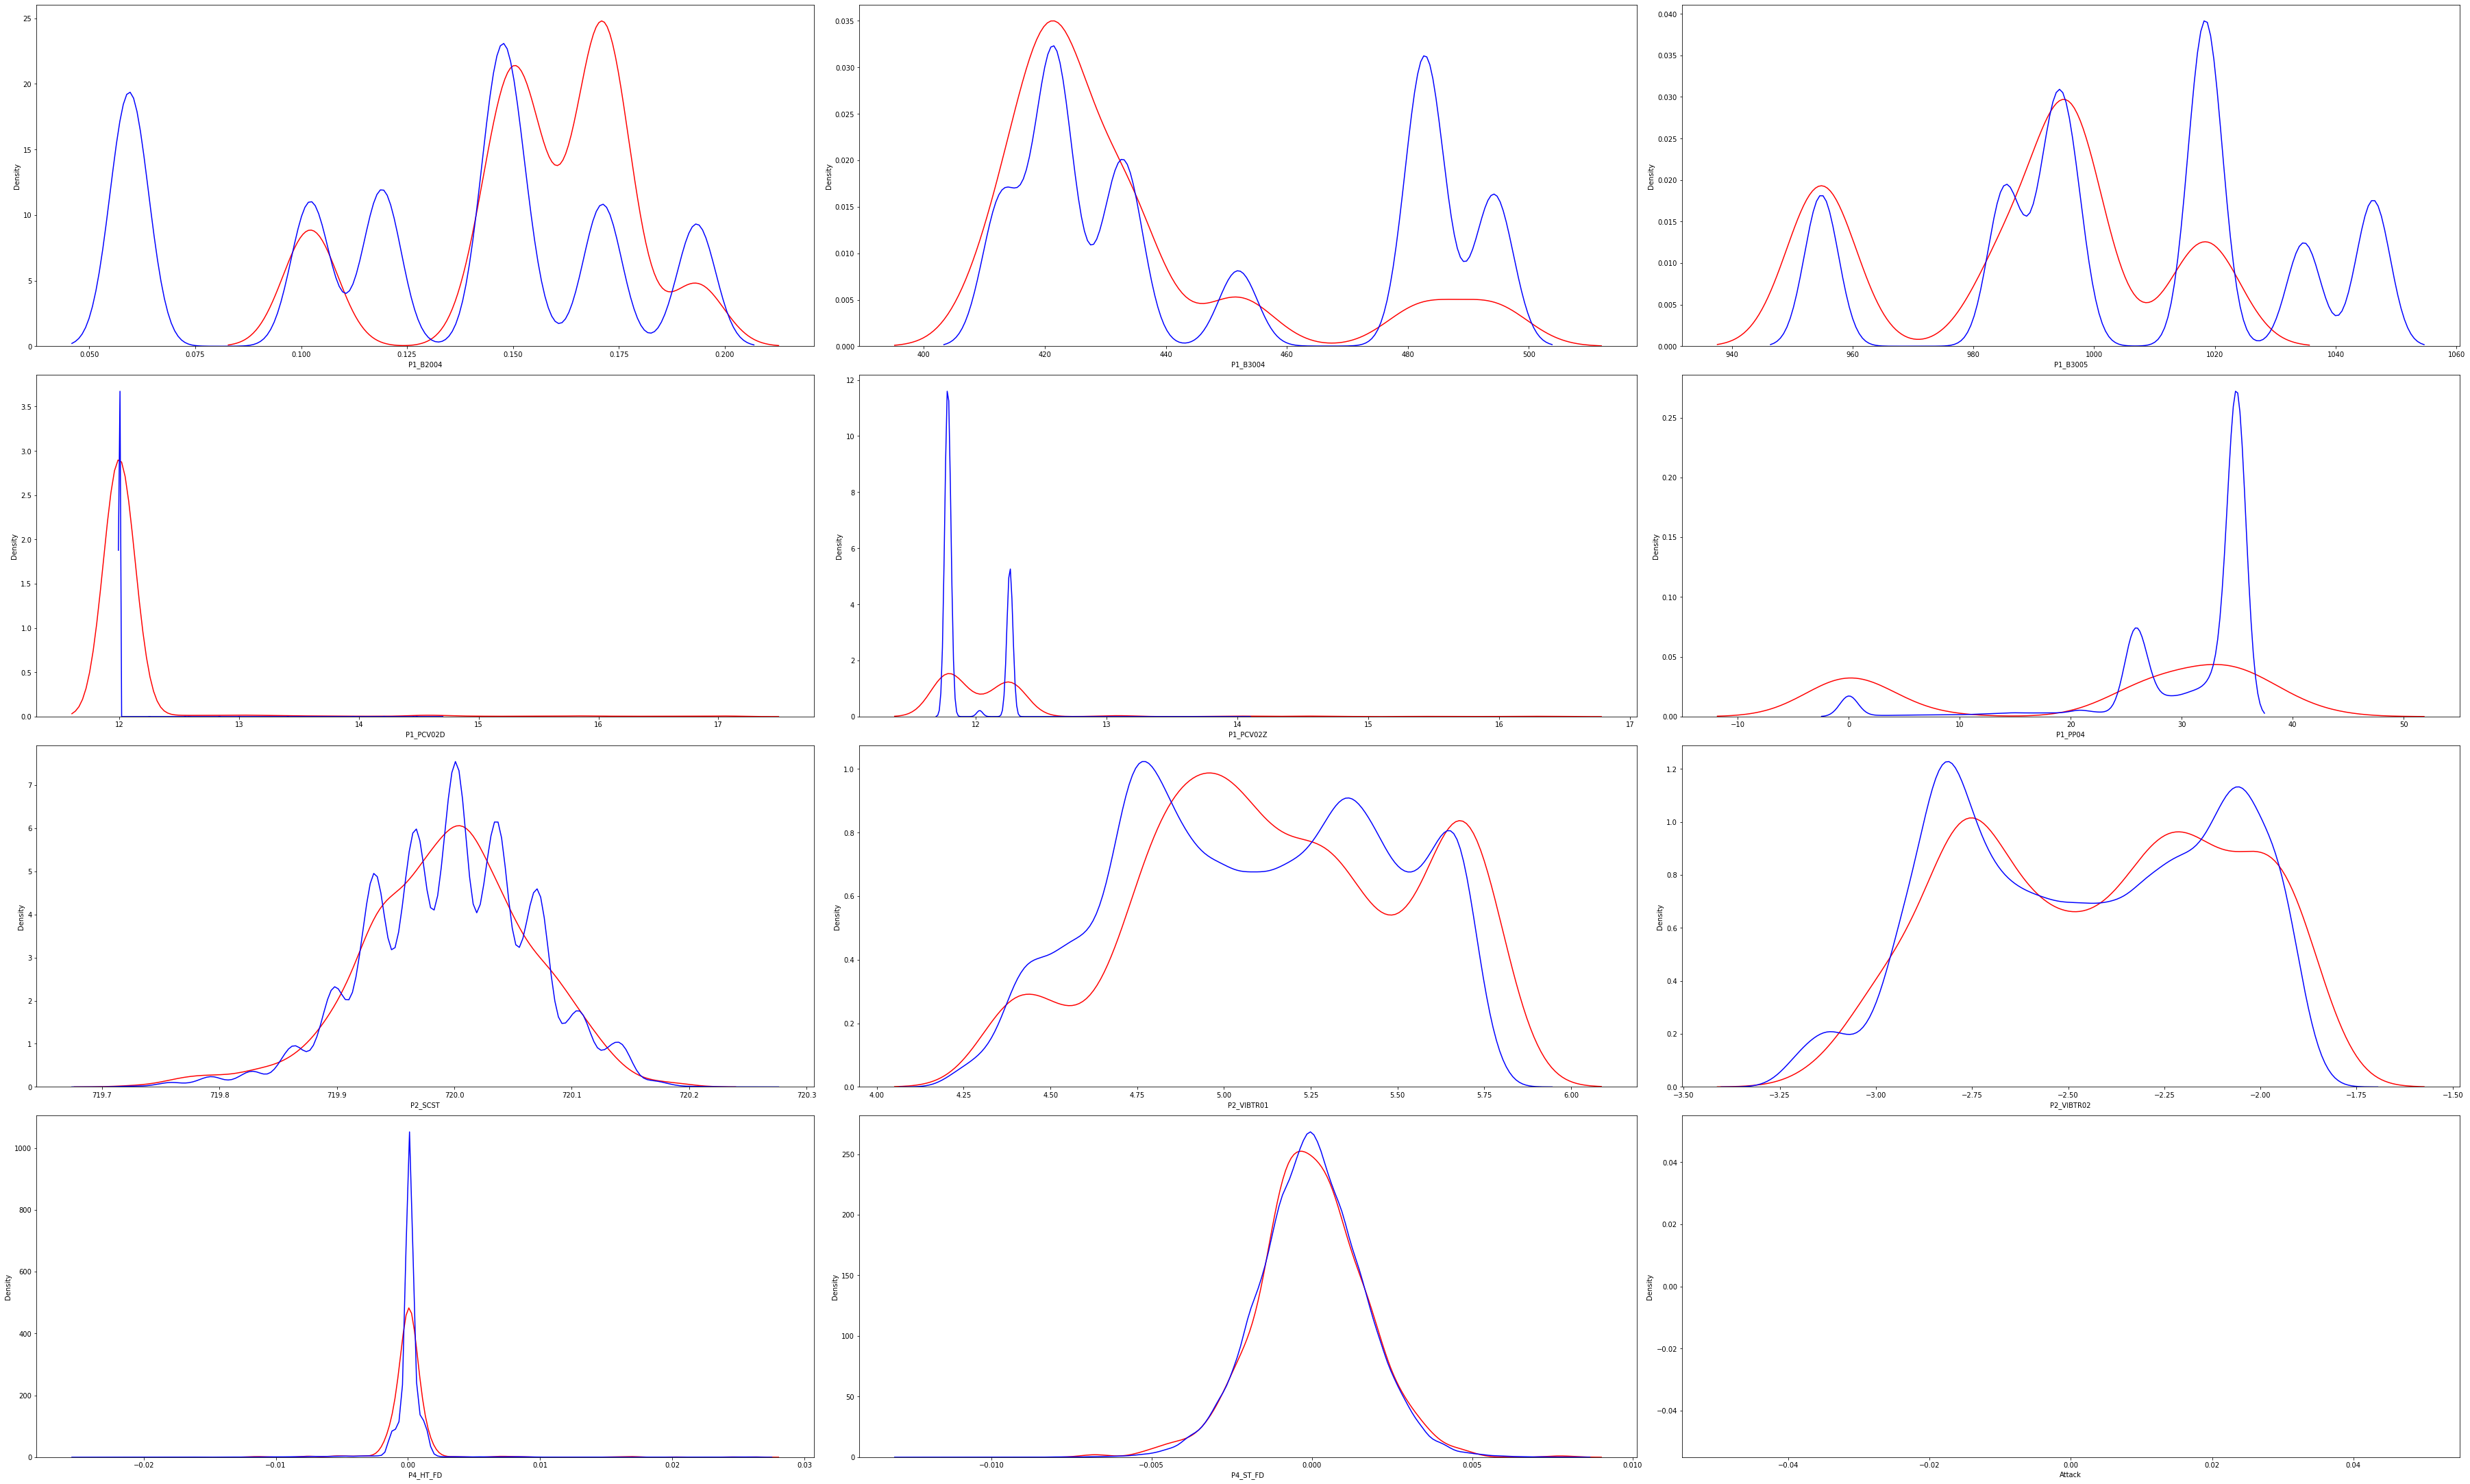

In [0]:
fig, ax = plt.subplots (4, 3, figsize = (50, 30))
row_count = 0
col_count = 0

for col in attack:
    sns.kdeplot(attack[col], color = 'r' , ax = ax[row_count][col_count])
    sns.kdeplot(normal[col], color = 'b' , ax = ax[row_count][col_count])
    print(row_count, col_count, col)

    col_count +=1
    if col_count >= 3:
        col_count = 0
        row_count +=1
    

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


Above image shows, most of these columns vary from attack to normal dataset, making their features important

# creating a sliding window for time series data

- a portion of the time series data will be imported through a sliding window and the pattern of the window gets memorized
- the sliding window is set to 90 seconds (HAI is sampled every second)

the input and output of the model were set as follows.

  Input: Value corresponding to the first 89 seconds of the window
  Output: the value of the last second (90th second) of the window
In subsequent detections, we looked at the difference between the value output by the model (predicted value) and the value that actually came in, and if the difference was large, it was considered an anomaly. The assumption is that many errors are due to patterns that have never been seen in the training dataset before

In [0]:
# WINDOW_GIVEN = 89
# WINDOW_SIZE = 90


# class HaiDataset(Dataset):
#     def __init__(self, timestamps, df, stride=1, attacks=None):
#         self.ts = np.array(timestamps)
#         self.tag_values = np.array(df, dtype=np.float32)
#         self.valid_idxs = []
#         for L in trange(len(self.ts) - WINDOW_SIZE + 1):
#             R = L + WINDOW_SIZE - 1
#             if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
#                 self.ts[L]
#             ) == timedelta(seconds=WINDOW_SIZE - 1):
#                 self.valid_idxs.append(L)
#         self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
#         self.n_idxs = len(self.valid_idxs)
#         print(f"# of valid windows: {self.n_idxs}")
#         if attacks is not None:
#             self.attacks = np.array(attacks, dtype=np.float32)
#             self.with_attack = True
#         else:
#             self.with_attack = False

#     def __len__(self):
#         return self.n_idxs

#     def __getitem__(self, idx):
#         i = self.valid_idxs[idx]
#         last = i + WINDOW_SIZE - 1
#         item = {"attack": self.attacks[last]} if self.with_attack else {}
#         item["ts"] = self.ts[i + WINDOW_SIZE - 1]
#         item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
#         item["answer"] = torch.from_numpy(self.tag_values[last])
#         return item

In [0]:
# train = HaiDataset(train_df_raw['timestamp'], train_df, stride=10)
# train[0]

## Convert pandas to numpy

In [0]:
train = np.array(train)
test = np.array(test)
train_target = np.array(train_target)
test_target = np.array(test_target)
test[0]

Out[146]: array([0. , 0.22638444, 0.87434463, 0. , 0.00495088,
 0.875 , 0.59480073, 0.48888889, 0.84126559, 0.49226605,
 0.63297872])

## One-Class SVM
- A one-class classifier is fit on a training dataset that only has examples from the normal class ( no anomalies ) 
- negative case (class 0) is taken as “normal” and the positive case (class 1) is taken as an outlier or anomaly
- OneClass SVM  is fit in an unsupervised manner and does not provide the normal hyperparameters for tuning the margin like C. Instead, it provides a hyperparameter “nu” that controls the sensitivity of the support vectors and should be tuned to the approximate ratio of outliers in the data
  - here our train data is 0% but our test data is 3.44% nu = 3.44 in terms of test but idk if thats what we want to do will test to see
- kernel is the kernel type to be used - svms ability to use non-linear function to project the space to higher dimensions. default is rbf = radial basis function
- gamma is a parameter of the rbf kernel type and controls the influence of individual training samples- affects the smootheness of the model
  - low gamma improves smoothenss and generalizability
  - high gamma reduces smoothness but makes model tighter- fitted
  - here we are going to start with 0.00005
- When calling the predict() function on the model, it will output a +1 for normal examples, so-called inliers, and a -1 for outliers.
- If we want to evaluate the performance of the model as a binary classifier, we must change the labels in the test dataset from 0 and 1 for the majority and minority classes respectively, to +1 and -1.


see https://machinelearningmastery.com/one-class-classification-algorithms/ 
and https://medium.com/@jamesstradling/unsupervised-machine-learning-with-one-class-support-vector-machines-129579a49d1d

## First attempt at the model
- removing all columns that are categorical
- removing all columns with no change 
- removing all columns that are 0 when normalized
- removing all columns with high collinearity (> 0.3)
- assuming non time dependent to start

will see how the model does, can slowly add more columns to see if accuracy improves

In [0]:
# instantiate a model and train it with training data
nu = (test_df_raw.Attack.value_counts()[-1])/(test_df_raw.Attack.value_counts()[1] + test_df_raw.Attack.value_counts()[-1]) # ratio of attack instances in test data
model = svm.OneClassSVM(nu=nu, kernel='rbf', gamma = 0.00005)
model.fit(train) 

Out[147]:

OneClassSVM(gamma=5e-05, nu=0.010243055555555556) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. OneClassSVM OneClassSVM(gamma=5e-05, nu=0.010243055555555556)

checking accuracy of the model

In [0]:
# use the predict function on our data and then use sklearn's built-in analysis functions to compare the labels between the predict output and our target
preds = model.predict(train)
targs = train_target 
print("accuracy: ", metrics.accuracy_score(targs, preds))
print("precision: ", metrics.precision_score(targs, preds)) 
print("recall: ", metrics.recall_score(targs, preds))
print("f1: ", metrics.f1_score(targs, preds))
# print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))

# shows the model predicts with 0.97 accuacy the class of the data from the training set (which is all normal)
# Precision, recall, F1, and AUC are all measures of the model’s effectiveness at predicting classes
# Closer to 1.0 they are, the better

accuracy: 0.9851176803666627
precision: 1.0
recall: 0.9851176803666627
f1: 0.9925030542115828

checking accuracy of the test set

In [0]:
preds = model.predict(test)
targs = test_target 
print("accuracy: ", metrics.accuracy_score(targs, preds))
print("precision: ", metrics.precision_score(targs, preds)) 
print("recall: ", metrics.recall_score(targs, preds))
print("f1: ", metrics.f1_score(targs, preds))
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))

# shows the model predicts with 3% accuacy the class of the data from the test set :(

accuracy: 0.9873958333333334
precision: 0.9899486989020172
recall: 0.9973922703619248
f1: 0.9936565447100009
area under curve (auc): 0.5094305984577985

In [0]:
model.get_params()

Out[150]: {'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'gamma': 5e-05,
 'kernel': 'rbf',
 'max_iter': -1,
 'nu': 0.010243055555555556,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [0]:
y_scores = model.score_samples(test)

In [0]:
len(y_scores)

Out[152]: 86400